# **Atmosphere Sanity Check**

## *Setup*


### Imports

Need to import wrf-python, cartopy, and netcdf in order to properly plot pressure, winds.

In [1]:
import os
from wrf import getvar, ALL_TIMES, extract_vars, omp_set_num_threads, omp_get_num_procs, to_np, smooth2d, interplevel, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
from netCDF4 import Dataset #type: ignore
import numpy as np
import cartopy.crs as crs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap

### Options & Basic Read In

Set the date, domain, plot type, and chem type. Adds basic variable read in. **NB:** Chem type is not ready to go yet beyond no chemistry (met option) 

In [2]:
year = 2023
month = 7
day = 21
hour = 18
domain = 2
plt_type = '850 hPa'
chem_type = 'met'
files = [f'./2023/wrfout/{f}' for f in os.listdir('./2023/wrfout/') if f.startswith(f'wrfout_d{domain:02}_{year}-{month:02}-{day:02}')]
files.sort()
wrffile = [Dataset(x) for x in files]
cache = extract_vars(wrffile, ALL_TIMES,('P','PSFC','PB','PH','PHB','T','QVAPOR','HGT','U','V','W'))
omp_set_num_threads(omp_get_num_procs())
if plt_type != 'sfc':
    z = getvar(wrffile, 'z', ALL_TIMES, units='dm', cache=cache)
else:
    z = getvar(wrffile, 'z', ALL_TIMES, units='m', cache=cache)
p = getvar(wrffile, 'pressure', ALL_TIMES, cache=cache)


### Specific Read In

This cell reads in the proper variables for the plot specified in the setup above. **NB:** chem_type is still not supported (9/14/2024)

In [3]:
if chem_type != 'met':
    #! not ready yet... xghg = wrf.
    raise NotImplementedError('Chem not implemented yet. Please reconfigure.') #TODO Come back to this.
elif plt_type == 'sfc':
    t2 = getvar(wrffile, 'T2', ALL_TIMES, cache=cache) - 273.15 # K -> deg C
    min_t2 = np.min(to_np(t2))
    max_t2 = np.max(to_np(t2))
    u_level, v_level = getvar(wrffile, 'uvmet10', ALL_TIMES, units='kt', cache=cache)
    z_level = getvar(wrffile,'slp', ALL_TIMES, cache=cache) #! Sea Level Pressure (slp) is added to z_level instead of height (z) for consistency in the plotting below.
else:
    ua = getvar(wrffile, 'ua', ALL_TIMES, units='kt', cache = cache)
    va = getvar(wrffile, 'va', ALL_TIMES, units='kt', cache = cache)
    u_level = interplevel(ua, p, 850. if plt_type == '850 hPa' else 500.)
    v_level = interplevel(va, p, 850. if plt_type == '850 hPa' else 500.)
    z_level = interplevel(z, p, 850. if plt_type == '850 hPa' else 500.)
lats, lons = latlon_coords(z)
z_level= smooth2d(z_level, 3, cenweight=4)
cart_proj = get_cartopy(z)

In [11]:
np.min(z_level)

<xarray.DataArray 'smooth_height_interp' ()> Size: 4B
array(141.59106, dtype=float32)
Coordinates:
    level    float64 8B 850.0

## *Plotting*

### Main Analysis Plot

This cell plots the analysis that is set up above. 

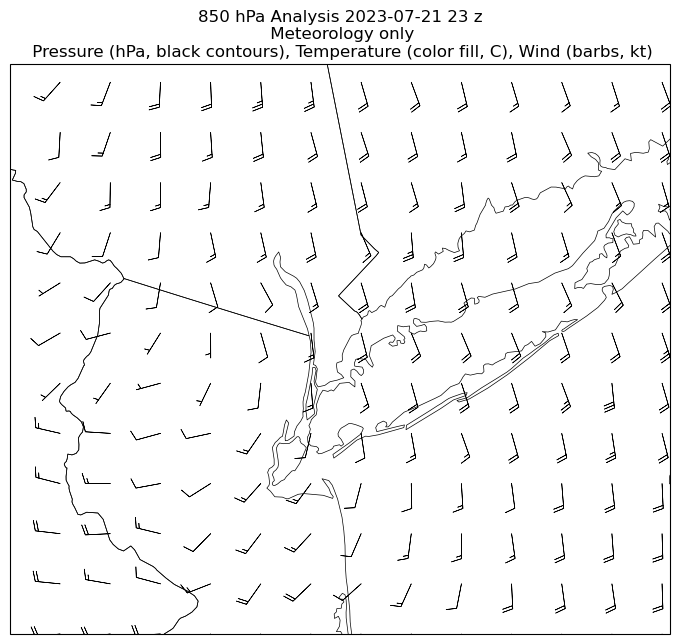

In [5]:
from matplotlib.animation import FuncAnimation as ani



golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
fig, ax = plt.subplots(1,1, subplot_kw={'projection': cart_proj},figsize=figsize)

#states = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',name='admin_1_states_provinces')
#lakes = NaturalEarthFeature(category='physical', scale='50m', facecolor='none', name='lakes')
states = cfeature.STATES
ax.add_feature(states, linewidth=0.5, edgecolor='black')
#ax.coastlines('50m', linewidth=0.5)

if chem_type != 'met':
    pass #TODO: come back to this
else:
    if plt_type == 'sfc':
        t_levels = np.arange(min_t2, max_t2, 0.1)
        t_contours = ax.contourf(to_np(lons), to_np(lats), to_np(t2[0, ...]), levels=t_levels, cmap=plt.get_cmap('rainbow'), transform=crs.PlateCarree())
        cbar_levels = np.arange(np.round(min_t2) - 1 , np.round(max_t2) + 1, 1)
        fig.colorbar(t_contours, ax=ax, orientation='horizontal', pad=0.05, ticks=cbar_levels, fraction=0.052, label=f'{"Surface" if plt_type=="sfc" else plt_type} Temperature ($^\circ$C)')
        levels = np.arange(1004., 1028., 4.)
    else:
        levels = np.arange(np.min(to_np(z_level)), np.max(to_np(z_level)), 4.)    
    ax.barbs(to_np(lons[::25, ::25]), to_np(lats[::25, ::25]), to_np(u_level[0, ::25, ::25]), to_np(v_level[0, ::25, ::25]), lw = 0.5, length=6, transform=crs.PlateCarree())
    contours = ax.contour(to_np(lons), to_np(lats), to_np(z_level[0,...]), levels= levels, linewidths= 0.5, colors='black', transform=crs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=10.)

ax.set_xlim(cartopy_xlim(z_level))
ax.set_ylim(cartopy_ylim(z_level))
ax.gridlines()

def animate(i):
    ax.clear()
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    if plt_type == 'sfc':
        t_contours = ax.contourf(to_np(lons), to_np(lats), to_np(t2[i, ...]), levels=t_levels, cmap=plt.get_cmap('rainbow'), transform=crs.PlateCarree())
        cbar_levels = np.arange(np.round(min_t2) - 1 , np.round(max_t2) + 1, 1)
    #fig.colorbar(t_contours, ax=ax, orientation='horizontal', pad=0.05, ticks=cbar_levels, fraction=0.052, label=f'{"Surface" if plt_type=="sfc" else plt_type} Temperature ($^\circ$C)')
    ax.barbs(to_np(lons[::25, ::25]), to_np(lats[::25, ::25]), to_np(u_level[i, ::25, ::25]), to_np(v_level[i, ::25, ::25]), lw = 0.5, length=6, transform=crs.PlateCarree())
    #levels = np.arange(1004., 1028., 4.)
    contours = ax.contour(to_np(lons), to_np(lats), to_np(z_level[i,...]), levels= levels, linewidths= 0.5, colors='black', transform=crs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=10.)
    ax.set_title(f'{"Surface" if plt_type=="sfc" else plt_type} Analysis {year}-{month:02}-{day:02} {i:02} z\n Meteorology only\n Pressure (hPa, black contours), Temperature (color fill, C), Wind (barbs, kt)')

if chem_type != 'met':
    pass #TODO: come back to this
else:
    anim = ani(fig, animate, interval=500, frames=24)
    anim.save(f'Nudged-{plt_type}-d{domain:02}-{year}-{month:02}-{day:02}.mp4')
    #plt.title(f'{"Surface" if plt_type=="sfc" else plt_type} Analysis {year}-{month:02}-{day:02} {hour:02} z\n Meteorology only\n Pressure (hPa, black contours), Temperature (color fill, C), Wind (barbs, kt)')
    #plt.savefig(f'Nudged-{plt_type}-d{domain:02}-{year}-{month:02}-{day:02}_{hour:02}z.png')
plt.show()
plt.close()

In [1]:
from wrf import omp_get_num_procs, omp_set_num_threads, omp_get_max_threads

In [2]:
print(omp_get_num_procs())

48


In [3]:
print(omp_get_max_threads())

1


In [4]:
omp_set_num_threads(30)

print(omp_get_max_threads())

30


In [5]:
from wrf import omp_enabled

print(omp_enabled())

True
